<a href="https://colab.research.google.com/github/1jgvc/sql-analisis/blob/main/SQL_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
#importamos librerias que se utilizaran
import pandas as pd
import matplotlib.pyplot as pl
import sqlite3
conn = sqlite3.connect('emergencias_ssa.db')
cursor = conn.cursor()

In [2]:
"""
Seleccionamos un dataset del catalogo
http://www.dgis.salud.gob.mx/contenidos/basesdedatos/Datos_Abiertos_gobmx.html

En este caso es el de urgencias en su ultima vesion hasta el momento
http://www.dgis.salud.gob.mx/descargas/datosabiertos/urgencias/Urgencias_2024.zip?v=2024.04.05
"""
%pwd
#asiganoms un nombre de salida para evitar contratiempos (tiene extencion zip!!)
urgencias_dir='urgencias-salud-data/'
data_file='urgencias-dataset-current.zip'
complete_path=urgencias_dir+data_file
%mkdir urgencias-salud-data
!wget -O $complete_path http://www.dgis.salud.gob.mx/descargas/datosabiertos/urgencias/Urgencias_2024.zip?v=2024.04.05


mkdir: cannot create directory ‘urgencias-salud-data’: File exists
--2024-06-09 07:20:53--  http://www.dgis.salud.gob.mx/descargas/datosabiertos/urgencias/Urgencias_2024.zip?v=2024.04.05
Resolving www.dgis.salud.gob.mx (www.dgis.salud.gob.mx)... 201.98.60.128
Connecting to www.dgis.salud.gob.mx (www.dgis.salud.gob.mx)|201.98.60.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46163532 (44M) [application/zip]
Saving to: ‘urgencias-salud-data/urgencias-dataset-current.zip’

urgencias-salud-dat 100%[===================>]  44.02M  13.9MB/s    in 3.5s    

2024-06-09 07:20:57 (12.6 MB/s) - ‘urgencias-salud-data/urgencias-dataset-current.zip’ saved [46163532/46163532]



In [7]:
#Descomprimimos el archivo
!unzip -o $complete_path -d $urgencias_dir

Archive:  urgencias-salud-data/urgencias-dataset-current.zip
  inflating: urgencias-salud-data/Registros/Afecciones.txt  
  inflating: urgencias-salud-data/Registros/Medicamentos.txt  
  inflating: urgencias-salud-data/Registros/Procedimientos.txt  
  inflating: urgencias-salud-data/Registros/Urgencias.txt  


In [36]:
#convertimos el dataset en pandaDataFrame
emergencies_file=urgencias_dir+"Registros/Urgencias.txt"
df_emergencies=pd.read_csv(emergencies_file, delimiter='|',engine='python')

In [63]:
cursor.execute("DROP TABLE IF EXISTS emergencias_raw")

#Insertamos todos los datos en nuestra base de datos de SQLite
df_emergencies.to_sql(name='emergencias_raw', con=conn)
#Limpiamos los datos que no son de sonora para liberar espacio en la maquina virtual de colab
#clean_emergency_SQL="DELETE FROM `emergencias_raw` WHERE ENTRESIDENCIA='26'"
#cursor.execute(clean_emergency_SQL)

1590328

In [64]:
#Creamos tabla emergency
create_emergency_SQL="CREATE TABLE IF NOT EXISTS `emergency`"
create_emergency_SQL+="(`eme_id` INTEGER PRIMARY KEY AUTOINCREMENT,"
create_emergency_SQL+="`eme_id_state` INT NOT NULL , `eme_id_city` INT NOT NULL,"
create_emergency_SQL+="`eme_date_start` DATE NOT NULL , `eme_sex` TINYINT NOT NULL);"
cursor.execute(create_emergency_SQL)


In [92]:

#Del catalogo Descriptores_Base_de_Datos_URGENCIAS_2008_2016 obtenemos el ID de Sonora=26
#Cargamos nuestra base de datos principal con los datos de sonora
populate_emergency_SQL="INSERT INTO `emergency` (eme_id_state,eme_id_city,eme_date_start,eme_sex) "
populate_emergency_SQL+="SELECT ENTRESIDENCIA,MUNRESIDENCIA,fechaingreso,SEXO FROM `emergencias_raw` WHERE ENTRESIDENCIA='26'"
cursor.execute(populate_emergency_SQL)

In [39]:
#Obtenemos el catalogo de municipios para utilizarlo en nuestro conjunto de datos y mostrar el nombre
catalog_city=urgencias_dir+"municipios.xlsx"
!wget -O $catalog_city http://gobi.salud.gob.mx/gobi/catalogos/catalogosmaestros/MUNICIPIOS_202404.xlsx?v=2024.05.15


--2024-06-09 04:30:17--  http://gobi.salud.gob.mx/gobi/catalogos/catalogosmaestros/MUNICIPIOS_202404.xlsx?v=2024.05.15
Resolving gobi.salud.gob.mx (gobi.salud.gob.mx)... 187.218.18.225
Connecting to gobi.salud.gob.mx (gobi.salud.gob.mx)|187.218.18.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72333 (71K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘urgencias-salud-data/municipios.xlsx’

urgencias-salud-dat 100%[===================>]  70.64K   264KB/s    in 0.3s    

2024-06-09 04:30:17 (264 KB/s) - ‘urgencias-salud-data/municipios.xlsx’ saved [72333/72333]



In [40]:
#Convertimos los municipios en un pandaDataFrame, en este caso es un archivo xlsx
df_cities = pd.read_excel(urgencias_dir+'municipios.xlsx')


#Insertamos todos los datos en nuestra base de datos de SQLite
df_cities.to_sql(name='municipios_raw', con=conn)

create_city_SQL="CREATE TABLE IF NOT EXISTS `cities` ("
create_city_SQL+="  `city_id` INTEGER,"
create_city_SQL+="  `city_name` TEXT NOT NULL,"
create_city_SQL+="  PRIMARY KEY(`city_id`));"
cursor.execute(create_city_SQL)

In [48]:
#Cargamos nuestra base de datos de ciudades con los datos de sonora
#Del catalogo Descriptores_Base_de_Datos_URGENCIAS_2008_2016 obtenemos el ID de Sonora=26
populate_emergency_SQL="INSERT INTO `cities` (city_id,city_name) "
populate_emergency_SQL+="SELECT CATALOG_KEY,MUNICIPIO FROM `municipios_raw` WHERE EFE_KEY='26'"
cursor.execute(populate_emergency_SQL)

In [46]:
#Creamos una vista de nuestros dos conjuntos de datos
cursor.execute("CREATE VIEW IF NOT EXISTS emergency_cities_view AS SELECT * FROM `emergency`,`cities` WHERE emergency.eme_id_city=cities.city_id;")

In [99]:
#Diferentes consultas de prueba para verificar que nuestras tablas tienen informacion
#test="SELECT * FROM `cities` LIMIT 10"
#test="SELECT * FROM `emergency` LIMIT 10 "
#test="SELECT * FROM `emergencias_raw` LIMIT 10 "
#df_test= pd.read_sql_query(test, conn)
#df_test

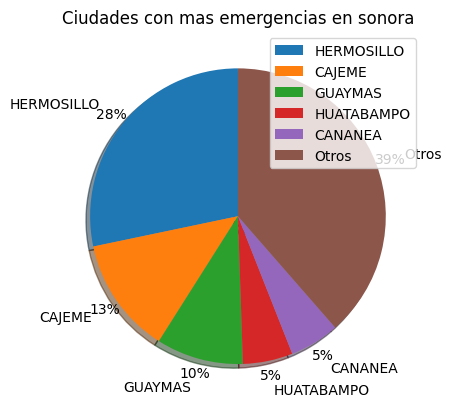

In [95]:
#Agrupamos por municipio, obtenemos los porcentajes de emergencias para todos y agrupamos los primeros cinco y todos los demas en otro calculo
cursor.execute("SELECT count(eme_id) FROM `emergency_cities_view`;")
total_eme=cursor.fetchone()[0]

emergency_byCity="SELECT city_id, city_name, count(eme_id) AS city_total, count(eme_id)/"+str(total_eme)+". AS city_percent FROM `emergency_cities_view` "
emergency_byCity+="GROUP BY `city_id` ORDER BY count(eme_id) DESC LIMIT 5;"
df_emergencies_top5= pd.read_sql_query(emergency_byCity, conn)
city_ids=df_emergencies_top5['city_id'].astype(str).str.cat(sep=', ')

emergency_byCityOthers="SELECT city_id, 'Otros' AS city_name, count(eme_id) AS city_total, count(eme_id)/"+str(total_eme)+". AS city_percent FROM `emergency_cities_view` "
emergency_byCityOthers+=" WHERE city_id NOT IN("+city_ids+")LIMIT 1;"
df_emergencies_other= pd.read_sql_query(emergency_byCityOthers, conn)

df_emergencies_all = df_emergencies_top5._append(df_emergencies_other, ignore_index=True)
plotTop5 = df_emergencies_all.plot(kind='pie',y='city_percent',labels=df_emergencies_all['city_name'], title="Ciudades con mas emergencias en sonora", label='',autopct='%1.0f%%',pctdistance=1.1, labeldistance=1.2,shadow=True, startangle=90)


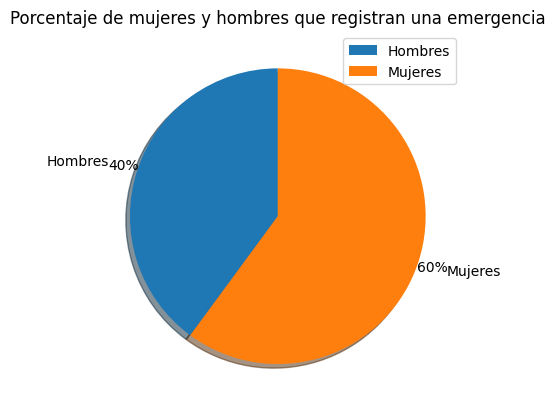

In [96]:
#Calculamos las emergencias por hombre y mujer
sex_rename=" CASE eme_sex WHEN 1 THEN 'Hombres' ELSE 'Mujeres' END eme_sex_alias "
emergency_bySex="SELECT count(eme_sex) AS 'total', "+sex_rename+", (count(eme_id)/"+str(total_eme)+".) AS percent FROM `emergency_cities_view` "
emergency_bySex+=" GROUP BY eme_sex HAVING eme_sex IN(1,2);"
df_emergencies_sex= pd.read_sql_query(emergency_bySex, conn)
plotbYsEX = df_emergencies_sex.plot(kind='pie',y='percent', labels=df_emergencies_sex['eme_sex_alias'], title="Porcentaje de mujeres y hombres que registran una emergencia", label='',autopct='%1.0f%%',pctdistance=1.1, labeldistance=1.2,shadow=True, startangle=90)


In [97]:
#Mas de la mitad de las emerjencias son de mujeres, esto podria explicarse por complicaciones de un embarazo?
#para ello se tendria que analizar  el campo AFECPRIN uniendolo con Descriptores_Base_de_Datos_URGENCIAS_2008_2016

#Hermosillo concentra una gran cantidad de emergencias seria interesante comparar contra el numero total de habitantes...

In [98]:
#Las ultimas 10 emergencias registradas ocurrieron en:
emergency_last10="SELECT  city_name, eme_date_start FROM `emergency_cities_view` ORDER BY eme_date_start DESC LIMIT 10;"
df_emergencies_last10= pd.read_sql_query(emergency_last10, conn)
#plotbYsEX = df_bySex.plot(kind='pie',y='percent', title="Porcentaje de mujeres y hombres que registran una emergencia", label='',autopct='%1.0f%%',pctdistance=1.1, labeldistance=1.2,shadow=True, startangle=90)
df_emergencies_last10

,city_name,eme_date_start
0,ALAMOS,2024-04-01
1,MAGDALENA,2024-03-31
2,IMURIS,2024-03-31
3,MAGDALENA,2024-03-31
4,MAGDALENA,2024-03-31
5,HERMOSILLO,2024-03-31
6,MAGDALENA,2024-03-31
7,MAGDALENA,2024-03-31
8,MAGDALENA,2024-03-31
9,MAGDALENA,2024-03-31


In [84]:
conn.close()